# Analysis of CheXpert Response Knowledge Distillation

In [2]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode()
import plotly.io as pio
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
import math
import re
import os
import seaborn as sns
plt.rcParams['figure.dpi'] = 250

### Teacher: 
- Resnet34, Seed 43

### Students:
No Female:
- Resnet18: Seeds 44, 46
- Resnet34: Seeds 45, 46

No Old:
- Resnet18: Seeds 42, 46
- Resnet34: Seeds 42, 45

No White:
- Resnet18: Seeds 42, 46
- Resnet34: Seeds 44, 46

### Read Data

In [3]:
def read_data(path, teacher_id=None):
    test_data = []
    for folder in os.scandir(path):
        if teacher_id is not None:
            if folder.is_dir() and teacher_id in folder.name:
                # Perform operations on the folder
                file_path = path + folder.name
                if os.path.exists(file_path + '/test.csv'):
                    df_tmp = pd.read_csv(file_path + '/test.csv')
                    test_data.append(df_tmp)
        else:
            if folder.is_dir():
                # Perform operations on the folder
                file_path = path + folder.name
                if os.path.exists(file_path + '/test.csv'):
                    df_tmp = pd.read_csv(file_path + '/test.csv')
                    test_data.append(df_tmp)

    df = pd.concat(test_data)
    df['auc_gap_relative'] = df['auc_gap'] / df['auc']
    df['age_auc'] = (df['age_auc_group_0'] + df['age_auc_group_1']) / 2
    df['sex_auc'] = (df['sex_auc_group_0'] + df['sex_auc_group_1']) / 2
    df['race_auc'] = (df['race_auc_group_0'] + df['race_auc_group_1']) / 2
    df['age_auc_gap'] = abs(df['age_auc_group_0'] - df['age_auc_group_1'])
    df['sex_auc_gap'] = abs(df['sex_auc_group_0'] - df['sex_auc_group_1'])
    df['race_auc_gap'] = abs(df['race_auc_group_0'] - df['race_auc_group_1'])
    df['avg_auc_gap'] = (df['age_auc_gap'] + df['sex_auc_gap'] + df['race_auc_gap']) / 3
    df['age_auc_gap_relative'] = df['age_auc_gap'] / df['auc']
    df['sex_auc_gap_relative'] = df['sex_auc_gap'] / df['auc']
    df['race_auc_gap_relative'] = df['race_auc_gap'] / df['auc']
    df['avg_auc_gap_relative'] = df['avg_auc_gap'] / df['auc']
    return df

original_df = read_data('../../results/chexpert/resnet/')
kd_no_female_df = read_data('../../results/chexpert_no_female/kd/', 'r34-sam1-s43')
kd_no_old_df = read_data('../../results/chexpert_no_old/kd/', 'r34-sam1-s43')
kd_no_white_df = read_data('../../results/chexpert_no_white/kd/', 'r34-sam1-s43')

no_female_df = read_data('../../results/chexpert_no_female/resnet/')
no_female_df = no_female_df[no_female_df['model_name'].isin(['resnet18', 'resnet34'])]

no_old_df = read_data('../../results/chexpert_no_old/resnet/')
no_old_df = no_old_df[no_old_df['model_name'].isin(['resnet18', 'resnet34'])]

no_white_df = read_data('../../results/chexpert_no_white/resnet/')
no_white_df = no_white_df[no_white_df['model_name'].isin(['resnet18', 'resnet34'])]

print(original_df.shape, kd_no_female_df.shape, kd_no_old_df.shape, no_female_df.shape, no_old_df.shape, kd_no_white_df.shape, no_white_df.shape)

(60, 93) (10, 94) (10, 94) (10, 94) (10, 94) (10, 94) (10, 94)


### Overall Analysis (for all students)

#### Table

In [3]:
def overall_kd_table(
    resnet_df: pd.DataFrame, # baseline
    kd_df: pd.DataFrame,    # kd results
    original_df: pd.DataFrame, # df to take the teacher performance from
    teacher_id: str, # teacher id
    metrics: list[str] = ['auc', 'auc_gap', 'auc_gap_relative', 'age_auc_gap_relative', 'sex_auc_gap_relative', 'race_auc_gap_relative', 'avg_auc_gap_relative'],
):
    teacher_df = original_df[original_df['model_id'] == teacher_id]
    teacher_df = teacher_df[metrics]

    # get the average baseline performance by model
    resnet_df = resnet_df.groupby(['model_name']).mean()
    print(resnet_df['auc'].mean().round(5))
    print(resnet_df['avg_auc_gap_relative'].mean().round(5))
    resnet_df = resnet_df[metrics]

    # get the average kd performance by model
    kd_df = kd_df.groupby(['model_name']).mean()
    kd_df = kd_df[metrics]

    # get the relative change in performance compared to the baseline
    kd_relative_df = ((kd_df - resnet_df) / resnet_df)

    teacher_df['Data'] = 'Teacher'
    resnet_df['Data'] = 'Baseline'
    kd_df['Data'] = 'KD'
    kd_relative_df['Data'] = 'Relative Change'
    df = pd.concat([teacher_df, resnet_df, kd_df, kd_relative_df])
    display(df)


In [4]:
print('No Female')
overall_kd_table(
    no_female_df,
    kd_no_female_df,
    original_df,
    'r34-sam1-s43',
)

print('No Old')
overall_kd_table(
    no_old_df,
    kd_no_old_df,
    original_df,
    'r34-sam1-s43',
)

print('No White')
overall_kd_table(
    no_white_df,
    kd_no_white_df,
    original_df,
    'r34-sam1-s43',
)

No Female
0.8221
0.03389


/tmp/ipykernel_2698280/613473744.py:12: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/tmp/ipykernel_2698280/613473744.py:18: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



auc   auc_gap  auc_gap_relative  age_auc_gap_relative  \
0         0.859081  0.041050          0.047784              0.047784   
resnet18  0.828371  0.052362          0.063477              0.059696   
resnet34  0.815831  0.060895          0.074831              0.074265   
resnet18  0.859311  0.041610          0.048421              0.048421   
resnet34  0.860136  0.041882          0.048693              0.048693   
resnet18  0.037350 -0.205344         -0.237192             -0.188871   
resnet34  0.054307 -0.312232         -0.349294             -0.344342   

          sex_auc_gap_relative  race_auc_gap_relative  avg_auc_gap_relative  \
0                     0.008222               0.001503              0.019170   
resnet18              0.031344               0.009897              0.033646   
resnet34              0.025056               0.003105              0.034142   
resnet18              0.008949               0.001385              0.019585   
resnet34              0.007455               0.002581              0.019576   
resnet18             -0.714497              -0.860038             -0.417903   
resnet34             -0.702479              -0.168714             -0.426628   

                     Data  
0                 Teacher  
resnet18         Baseline  
resnet34         Baseline  
resnet18               KD  
resnet34               KD  
resnet18  Relative Change  
resnet34  Relative Change

No Old
0.84043
0.02389


/tmp/ipykernel_2698280/613473744.py:12: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/tmp/ipykernel_2698280/613473744.py:18: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



auc   auc_gap  auc_gap_relative  age_auc_gap_relative  \
0         0.859081  0.041050          0.047784              0.047784   
resnet18  0.841132  0.052551          0.062518              0.062518   
resnet34  0.839725  0.045564          0.054245              0.053385   
resnet18  0.859147  0.041903          0.048772              0.048772   
resnet34  0.860578  0.041581          0.048318              0.048318   
resnet18  0.021417 -0.202613         -0.219877             -0.219877   
resnet34  0.024833 -0.087407         -0.109266             -0.094915   

          sex_auc_gap_relative  race_auc_gap_relative  avg_auc_gap_relative  \
0                     0.008222               0.001503              0.019170   
resnet18              0.009376               0.003622              0.025172   
resnet34              0.010160               0.004259              0.022601   
resnet18              0.006863               0.002089              0.019241   
resnet34              0.007308               0.002003              0.019209   
resnet18             -0.267969              -0.423257             -0.235602   
resnet34             -0.280772              -0.529781             -0.150083   

                     Data  
0                 Teacher  
resnet18         Baseline  
resnet34         Baseline  
resnet18               KD  
resnet34               KD  
resnet18  Relative Change  
resnet34  Relative Change

No White
0.82731
0.02228


/tmp/ipykernel_2698280/613473744.py:12: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/tmp/ipykernel_2698280/613473744.py:18: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



auc   auc_gap  auc_gap_relative  age_auc_gap_relative  \
0         0.859081  0.041050          0.047784              0.047784   
resnet18  0.822762  0.044148          0.053694              0.053457   
resnet34  0.831856  0.046293          0.055647              0.055647   
resnet18  0.857280  0.040429          0.047158              0.047158   
resnet34  0.857321  0.040769          0.047553              0.047553   
resnet18  0.041954 -0.084251         -0.121721             -0.117831   
resnet34  0.030612 -0.119331         -0.145465             -0.145465   

          sex_auc_gap_relative  race_auc_gap_relative  avg_auc_gap_relative  \
0                     0.008222               0.001503              0.019170   
resnet18              0.009605               0.004382              0.022481   
resnet34              0.008728               0.001861              0.022079   
resnet18              0.006156               0.002156              0.018490   
resnet34              0.007745               0.002334              0.019211   
resnet18             -0.359041              -0.508054             -0.177537   
resnet34             -0.112596               0.254127             -0.129904   

                     Data  
0                 Teacher  
resnet18         Baseline  
resnet34         Baseline  
resnet18               KD  
resnet34               KD  
resnet18  Relative Change  
resnet34  Relative Change

#### Plots

In [7]:
def kd_overall_model_performance(
        resnet_df: pd.DataFrame,
        kd_df: pd.DataFrame,
        teacher_df: pd.DataFrame,
        teacher_id: str,
        metric: str,
        title: str = '',
        bar_width=0.5, 
        line_length=0.05,
    ):

    kd_df = kd_df.sort_values(by=['model_name'])
    # Get teachers from resnet_df
    teacher_performance = teacher_df[teacher_df['model_id'] == teacher_id][metric]
                            
    # Set up graphical variables
    total_bars = 2 # TODO: Change maybe
    bar_group_width = bar_width * total_bars
    legend_handles = []
    legend_labels = []

    # Set up the plot
    fig, ax = plt.subplots(figsize=(9, 7))

    # Create the plot
    for i, model in enumerate(kd_df['model_name'].unique()):
        model_scores = []

        # Get without KD
        scores = resnet_df[(resnet_df['model_name'] == model)][metric]
        mean_score = scores.mean()
        std_error = scores.std()
        model_scores.append(mean_score)
        x_pos_no_kd = i - bar_group_width/2 + (0 + 0.5) * bar_width
        handle_no_kd = ax.errorbar(x_pos_no_kd, mean_score, yerr=std_error, marker='D', capsize=5, markersize=12, markerfacecolor='blue', markeredgecolor='black', ecolor='gray', linewidth=0.9)
        if 'Baseline: No KD' not in legend_labels:
            legend_handles.append(handle_no_kd)
            legend_labels.append('Baseline: No KD')

        # Get with KD
        scores = kd_df[(kd_df['model_name'] == model)][metric]
        mean_score = scores.mean()
        std_error = scores.std()
        model_scores.append(mean_score)
        x_pos_kd = i - bar_group_width/2 + (1 + 0.5) * bar_width
        handle_kd = ax.errorbar(x_pos_kd, mean_score, yerr=std_error, marker='o', capsize=5, markersize=12, markerfacecolor='orange', markeredgecolor='black', ecolor='gray', linewidth=0.9)
        if 'With KD' not in legend_labels:
            legend_handles.append(handle_kd)
            legend_labels.append('With KD')

        # Draw a dotted line between No KD and KD
        ax.plot([x_pos_no_kd, x_pos_kd], [model_scores[0], model_scores[1]], linestyle=':', color='grey')


    # Show Teacher performance:
    teacher = ax.axhline(y=teacher_performance[0], linestyle='-', label='Teacher', linewidth=0.9, zorder=1, color='red')
    legend_handles.append(teacher)
    legend_labels.append('Teacher Performance')
    # Add text above the teacher performance line
    ax.text(-0.45, teacher_performance[0], 'Teacher Performance', color='black', va='bottom')

    # Customize the plot
    ax.set_xticks(np.arange(len(kd_df['model_name'].unique())))
    ax.set_xticklabels(kd_df['model_name'].unique(), fontsize=15)
    ax.set_ylabel(metric, fontsize=15) 
    # Set the x-axis limits to show all the error bars
    ax.set_xlim(-bar_group_width/2, len(kd_df['model_name'].unique())-1+bar_group_width/2)
    ax.set_facecolor('#F0F0F0')
    # Legend
    ax.legend(handles=legend_handles, labels=legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', handlelength=3.0, handletextpad=0.5, prop={'size': 12})
    # Grid
    ax.yaxis.grid(True, linestyle='dotted', linewidth=0.8, color='white', alpha=1)
    # Title
    fig.suptitle(title, fontsize=15, y=0.92)

    # plt.show()

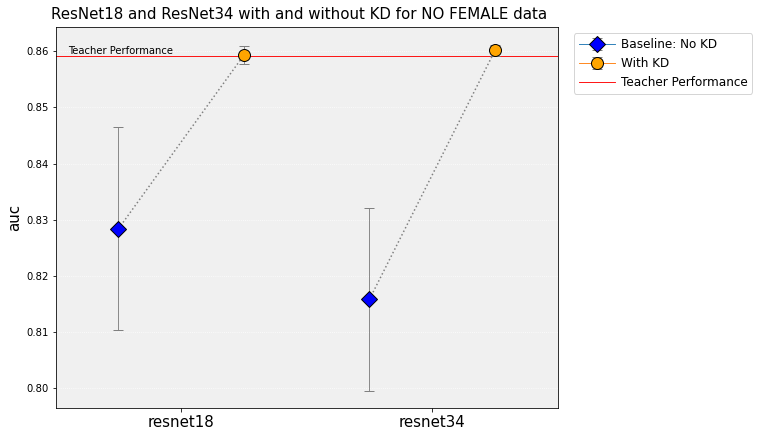

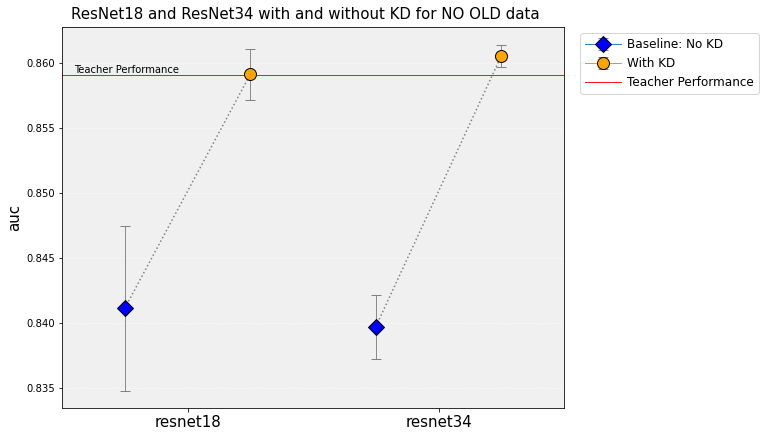

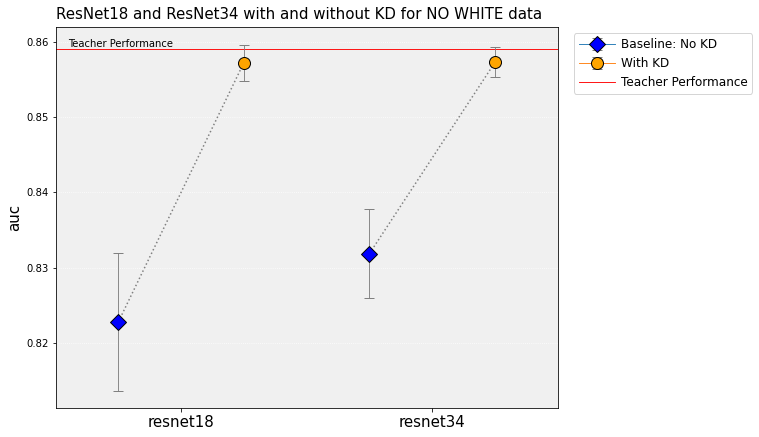

In [8]:
kd_overall_model_performance(
    no_female_df,
    kd_no_female_df,
    original_df,
    'r34-sam1-s43',
    'auc',
    title='ResNet18 and ResNet34 with and without KD for NO FEMALE data',
)

kd_overall_model_performance(
    no_old_df,
    kd_no_old_df,
    original_df,
    'r34-sam1-s43',
    'auc',
    title='ResNet18 and ResNet34 with and without KD for NO OLD data',
)

kd_overall_model_performance(
    no_white_df,
    kd_no_white_df,
    original_df,
    'r34-sam1-s43',
    'auc',
    title='ResNet18 and ResNet34 with and without KD for NO WHITE data',
)

In [174]:
experiment_colors = {
    "sex_no_kd": "violet",
    "age_no_kd": "gold",
    "sex_kd": "darkviolet",
    "age_kd": "orange",
    "race_no_kd": "limegreen",
    "race_kd": "darkgreen",
}


def kd_overall_model_subgroup_performance(
        resnet_df: pd.DataFrame,
        kd_df: pd.DataFrame,
        teacher_df: pd.DataFrame,
        subgroups: list[str],
        teacher_id: str,
        metric: str,
        title: str = '',
        bar_width=0.5, 
        line_length=0.05,
    ):

    kd_df = kd_df.sort_values(by=['model_name'])

    age_metric = 'age_' + metric
    sex_metric = 'sex_' + metric
    race_metric = 'race_' + metric

    # Get teachers from resnet_df
    age_teacher_performance = teacher_df[teacher_df['model_id'] == teacher_id][age_metric][0]
    sex_teacher_performance = teacher_df[teacher_df['model_id'] == teacher_id][sex_metric][0]
    race_teacher_performance = teacher_df[teacher_df['model_id'] == teacher_id][race_metric][0]
                            
    # Set up graphical variables
    total_bars = 3 # TODO: Change maybe
    bar_group_width = bar_width * total_bars
    legend_handles = []
    legend_labels = []

    # Set up the plot
    fig, ax = plt.subplots(figsize=(11, 7))

    # Create the plot
    for i, data in enumerate(kd_df['data'].unique()):
        for j, subgroup in enumerate(subgroups):
            model_scores = []
            subgroup_metric = subgroup + "_" + metric

            # Get without KD
            scores = resnet_df[(resnet_df['data'] == data)][subgroup_metric]
            mean_score = scores.mean()
            std_error = scores.std()
            model_scores.append(mean_score)
            x_pos_no_kd = i - bar_group_width/3 + (0 + 0.5) * bar_width
            handle_no_kd = ax.errorbar(x_pos_no_kd, mean_score, yerr=std_error, marker='D', capsize=5, markersize=12, markerfacecolor=experiment_colors[f'{subgroup}_no_kd'], markeredgecolor='black', ecolor='gray', linewidth=0.9)


            if f'{subgroup.capitalize()} w/o KD' not in legend_labels:
                legend_handles.append(handle_no_kd)
                legend_labels.append(f'{subgroup.capitalize()} w/o KD')

            # Get with KD
            scores = kd_df[(kd_df['data'] == data)][subgroup_metric]
            mean_score = scores.mean()
            std_error = scores.std()
            model_scores.append(mean_score)
            x_pos_kd = i - bar_group_width/3 + (1 + 0.5) * bar_width
            handle_kd = ax.errorbar(x_pos_kd, mean_score, yerr=std_error, marker='o', capsize=5, markersize=12, markerfacecolor=experiment_colors[f'{subgroup}_kd'], markeredgecolor='black', ecolor='gray', linewidth=0.9)

            
            if f'{subgroup.capitalize()} w/ KD' not in legend_labels:
                legend_handles.append(handle_kd)
                legend_labels.append(f'{subgroup.capitalize()} w/ KD')

            # Draw a dotted line between No KD and KD
            ax.plot([x_pos_no_kd, x_pos_kd], [model_scores[0], model_scores[1]], linestyle=':', color='grey')


    # Show Teacher performance:
    teacher_age = ax.axhline(y=age_teacher_performance, linestyle='-', label='Teacher', linewidth=0.9, zorder=1, color='red')
    legend_handles.append(teacher_age)
    legend_labels.append('Teacher Age\nAUC Gap')

    teacher_sex = ax.axhline(y=sex_teacher_performance, linestyle='-', label='Teacher', linewidth=0.9, zorder=1, color='violet')
    legend_handles.append(teacher_sex)
    legend_labels.append('Teacher Sex\nAUC Gap')

    teacher_race = ax.axhline(y=race_teacher_performance, linestyle='-', label='Teacher', linewidth=0.9, zorder=1, color='green')
    legend_handles.append(teacher_race)
    legend_labels.append('Teacher Race\nAUC Gap')

    # Add text above the teacher performance line
    # ax.text(0.4, age_teacher_performance, 'Teacher Age AUC Gap', color='black', va='bottom')
    # ax.text(0.4, sex_teacher_performance, 'Sex Teacher', color='black', va='bottom')
    # ax.text(0.4, race_teacher_performance, 'Race Teacher', color='black', va='bottom')

    # Customize the plot
    ax.set_xticks(np.arange(len(kd_df['data'].unique())))
    ax.set_xticklabels(kd_df['data'].unique(), fontsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylabel('AUC Gap', fontsize=15)
    ax.set_xlabel('Unfair Training Data', fontsize=15) 
    # add space between x label title and x ticks names
    ax.xaxis.labelpad = 10

    # Set legend title
    legend = ax.legend(handles=legend_handles, labels=legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', handlelength=3.0, handletextpad=0.5, prop={'size': 14}, labelspacing=0.8)
    legend.set_title('Subgroup AUC Gap', prop={'size': 15})
    # legend's face color:
    legend.get_frame().set_facecolor('#F0F0F0')
    # legend's border color:
    legend.get_frame().set_edgecolor('black')
    # set legend's opacity
    legend.get_frame().set_alpha(1)
    


    # # Set the x-axis limits to show all the error bars
    ax.set_xlim(-bar_group_width/3, len(kd_df['data'].unique())-1+bar_group_width/3)
    ax.set_facecolor('#F0F0F0')
    # # Legend
    # ax.legend(handles=legend_handles, labels=legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', handlelength=3.0, handletextpad=0.5, prop={'size': 12})
    # # Grid
    ax.yaxis.grid(True, linestyle='dotted', linewidth=0.8, color='white', alpha=1)
    # # Title
    fig.suptitle(title, fontsize=18, y=0.98)

    plt.show()

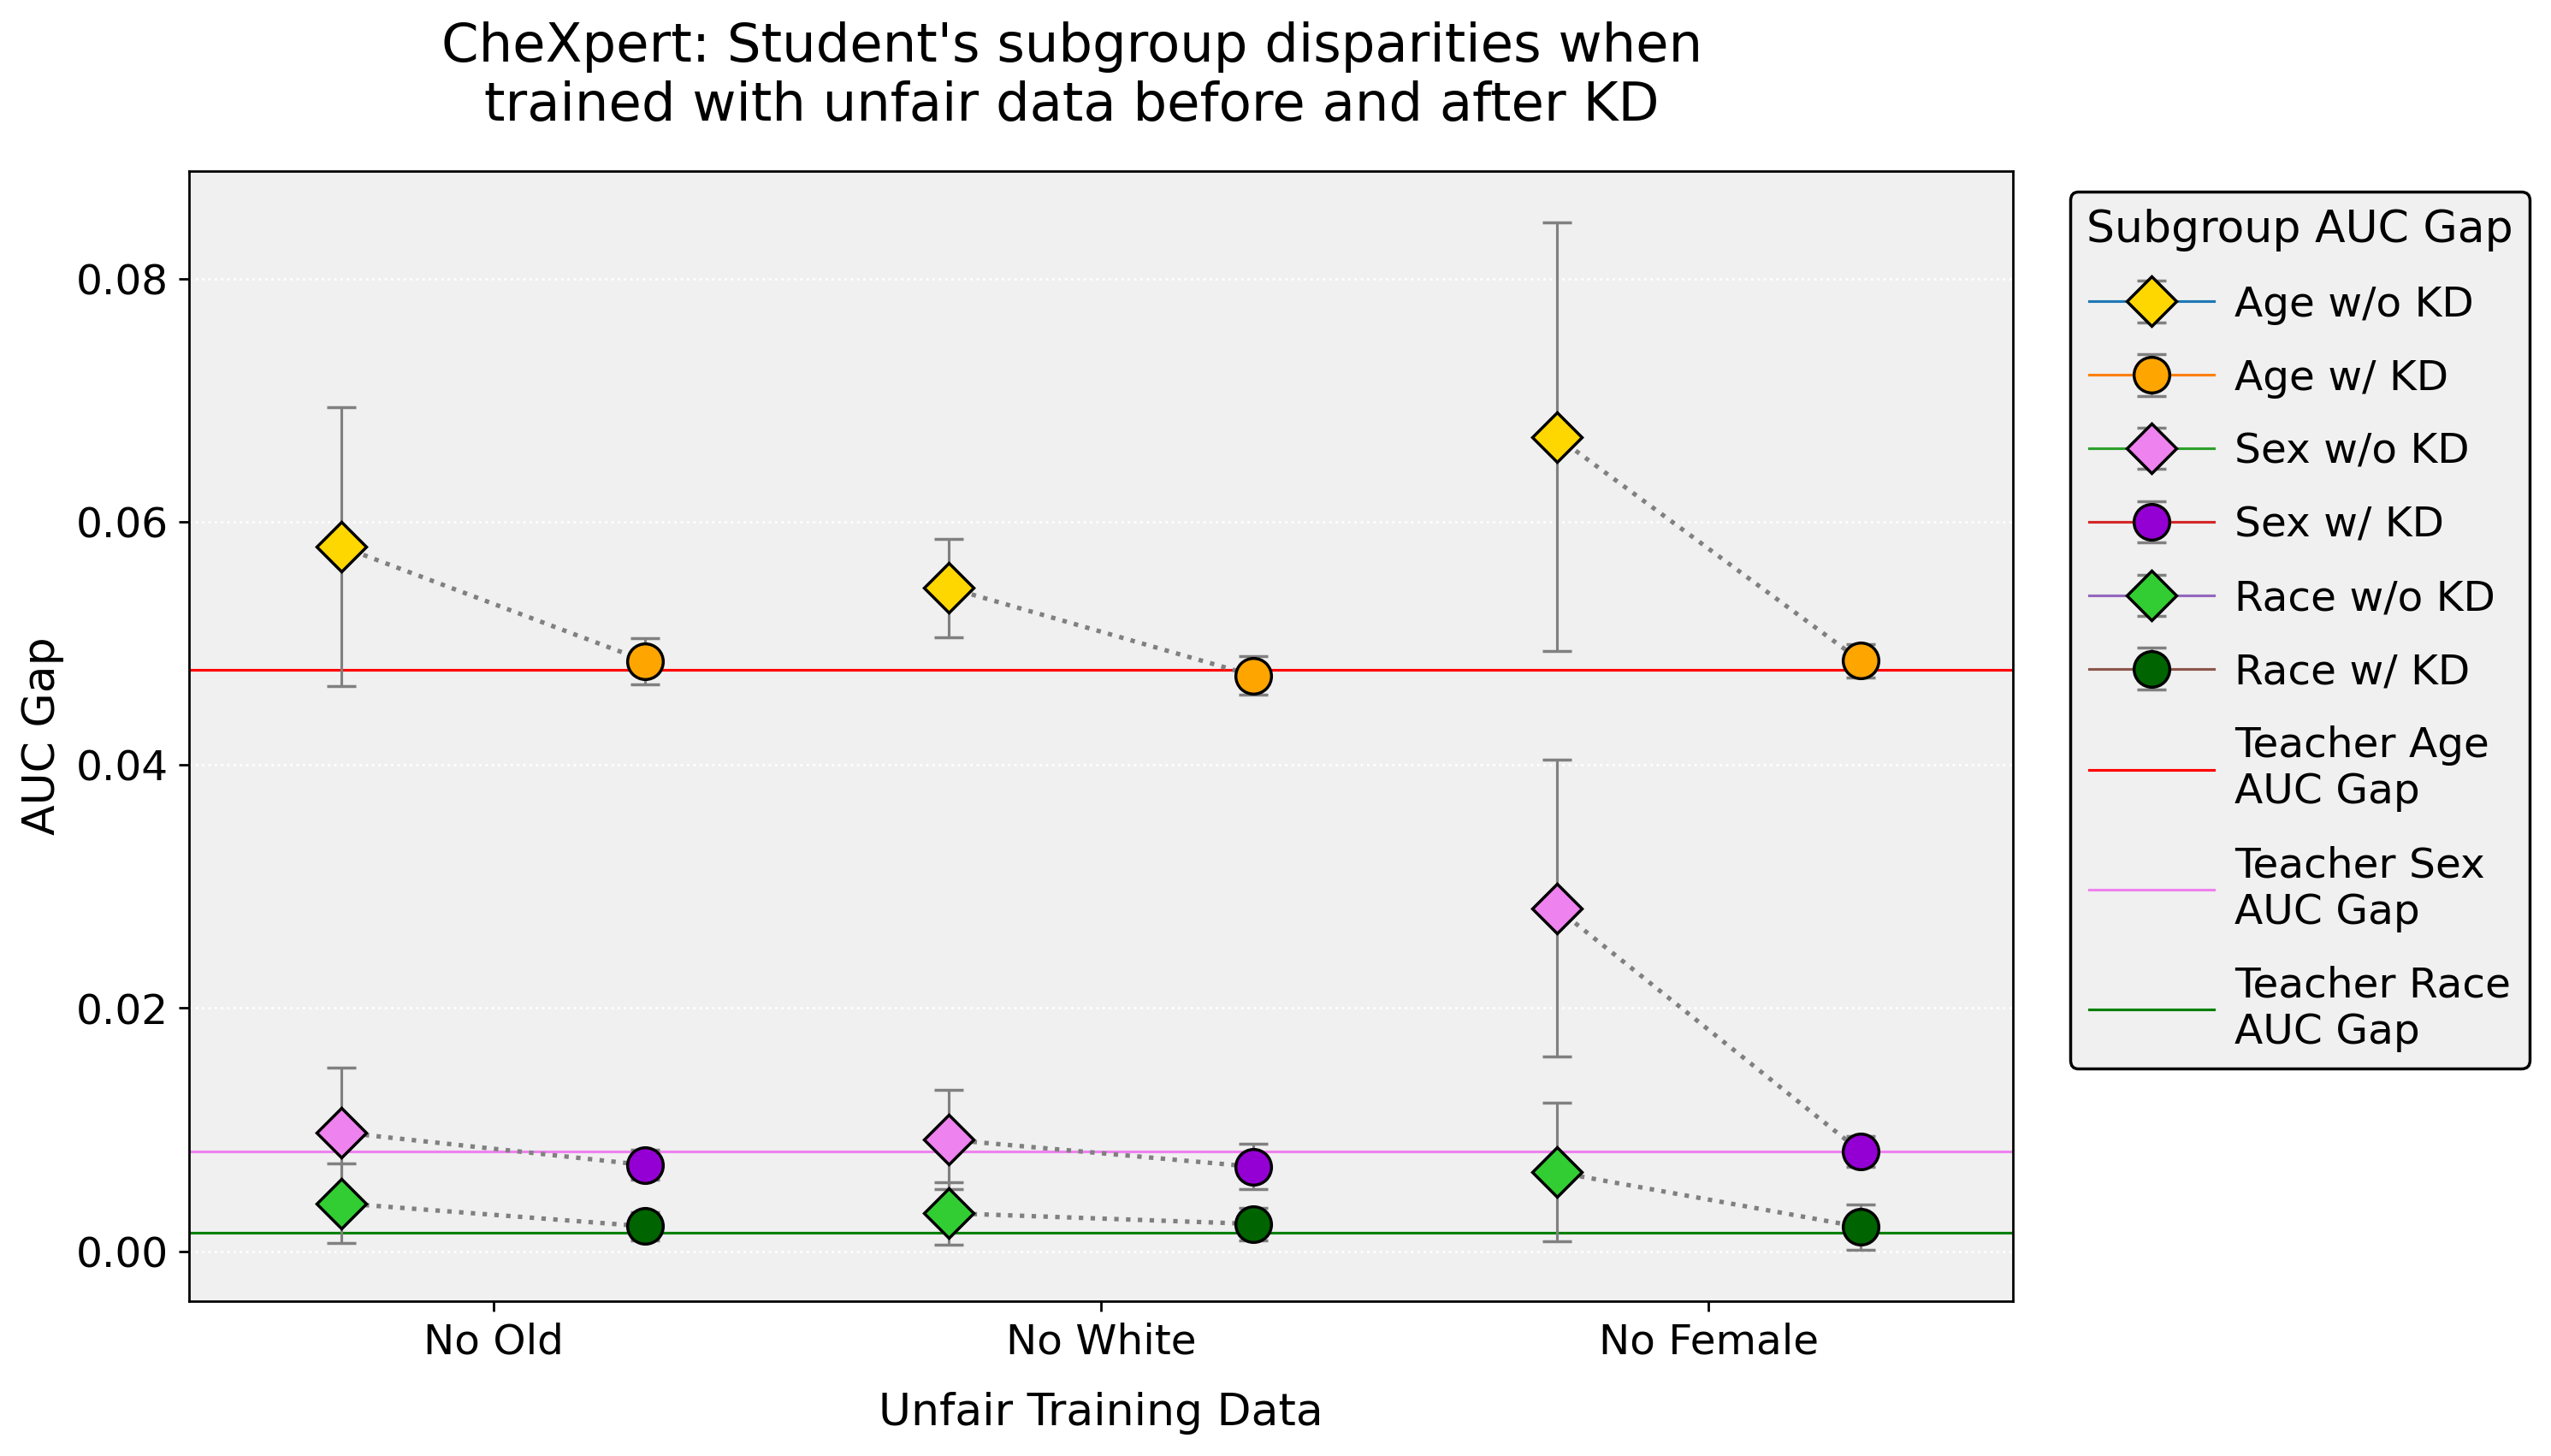

In [175]:
# Give them all_unfair_df at once

no_female_df['data'] = 'No Female'
no_old_df['data'] = 'No Old'
no_white_df['data'] = 'No White'
unfair_df = pd.concat([no_female_df, no_old_df, no_white_df])

kd_no_female_df['data'] = 'No Female'
kd_no_old_df['data'] = 'No Old'
kd_no_white_df['data'] = 'No White'
kd_unfair_df = pd.concat([kd_no_female_df, kd_no_old_df, kd_no_white_df])

kd_overall_model_subgroup_performance(
    unfair_df,
    kd_unfair_df,
    original_df,
    ['age', 'sex', 'race'],
    'r34-sam1-s43',
    'auc_gap_relative',
    title="CheXpert: Student's subgroup disparities when\ntrained with unfair data before and after KD"
)

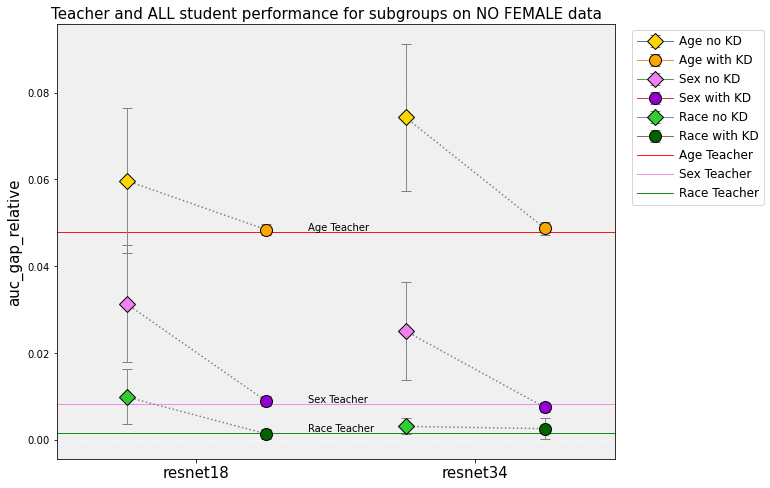

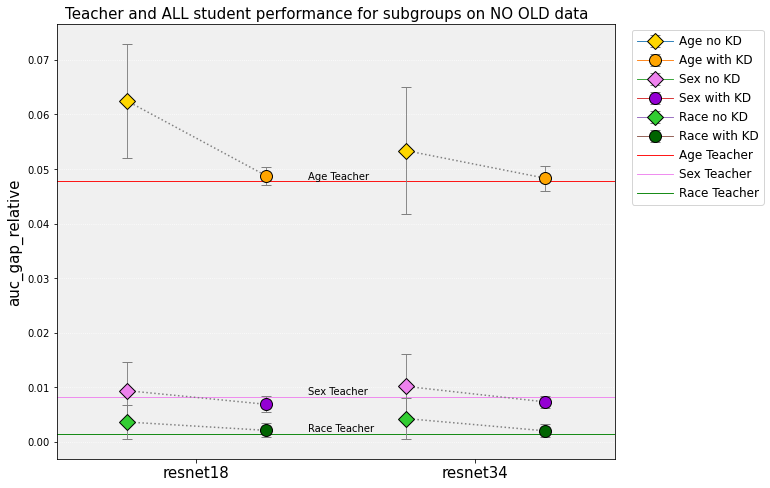

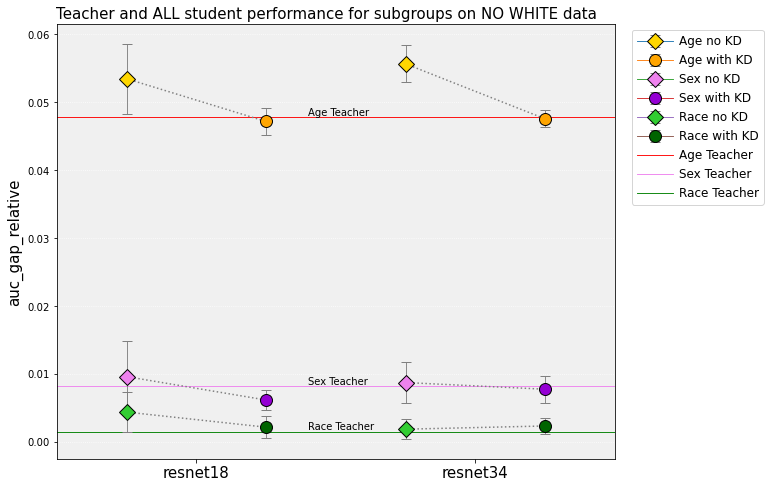

In [10]:
kd_overall_model_subgroup_performance(
    no_female_df,
    kd_no_female_df,
    original_df,
    ['age', 'sex', 'race'],
    'r34-sam1-s43',
    'auc_gap_relative',
    title='Teacher and ALL student performance for subgroups on NO FEMALE data'
)

kd_overall_model_subgroup_performance(
    no_old_df,
    kd_no_old_df,
    original_df,
    ['age', 'sex', 'race'],
    'r34-sam1-s43',
    'auc_gap_relative',
    title='Teacher and ALL student performance for subgroups on NO OLD data'
)

kd_overall_model_subgroup_performance(
    no_white_df,
    kd_no_white_df,
    original_df,
    ['age', 'sex', 'race'],
    'r34-sam1-s43',
    'auc_gap_relative',
    title='Teacher and ALL student performance for subgroups on NO WHITE data'
)

In [38]:
from typing import List
metric_names = {
    'auc': 'AUC',
    'age_auc_group_0': 'Age < 60',
    'age_auc_group_1': 'Age 60+',
    'sex_auc_group_0': 'Male',
    'sex_auc_group_1': 'Female',
    'race_auc_group_0': 'White',
    'race_auc_group_1': 'Non-White',
    'avg_auc_gap': 'Avg AUC Gap',
    'age_auc_gap': 'Age AUC Gap',
    'sex_auc_gap': 'Sex AUC Gap',
    'race_auc_gap': 'Race AUC Gap',
    'age_eq_odds': 'Age Eq. Odds',
    'sex_eq_odds': 'Sex Eq. Odds',
    'race_eq_odds': 'Race Eq. Odds',
}

def overall_radar_plot(
    resnet_df: pd.DataFrame, # baseline
    kd_df: pd.DataFrame,    # kd results
    original_df: pd.DataFrame, # df to take the teacher performance from
    metrics: List[str],
    teacher_id: str,
    student_model: str, # resnet18 or resnet34 or None
    title: str = 'title',
    is_performance: bool = True,
):
    # get the teacher performance
    teacher_df = original_df[original_df['model_id'] == teacher_id]
    teacher_df = teacher_df[metrics]
    teacher_df = teacher_df.rename(columns=metric_names)
    teacher_df = teacher_df.melt(var_name='metric', value_name='value')

    # get the average baseline performance by model
    if student_model is not None:
        student_baseline = resnet_df[resnet_df['model_name'] == student_model]
    else:
        student_baseline = resnet_df
    student_baseline = student_baseline[metrics]
    student_baseline = student_baseline.rename(columns=metric_names)
    student_baseline = student_baseline.mean().to_frame().T
    student_baseline = student_baseline.melt(var_name='metric', value_name='value')
    
    # get the average kd performance by model
    if student_model is not None:
        student_kd = kd_df[(kd_df['model_name'] == student_model) & (kd_df['teacher_id'] == teacher_id)]
    else:
        student_kd = kd_df[kd_df['teacher_id'] == teacher_id]
    student_kd = student_kd[metrics]
    student_kd = student_kd.rename(columns=metric_names)
    student_kd = student_kd.mean().to_frame().T
    student_kd = student_kd.melt(var_name='metric', value_name='value')

    # Add last element to create a circular effect
    teacher_df = teacher_df.append(teacher_df.iloc[0], ignore_index=True) 
    student_baseline = student_baseline.append(student_baseline.iloc[0], ignore_index=True) 
    student_kd = student_kd.append(student_kd.iloc[0], ignore_index=True) 

    fig = go.Figure()
    fig = px.line_polar(start_angle=90)

    # PERFORMANCE
    if is_performance:
        fig.add_trace(go.Scatterpolar(
            r=teacher_df['value'],
            theta=teacher_df['metric'],
            name='Teacher',
        ))
        fig.add_trace(go.Scatterpolar(
            r=student_kd['value'],
            theta=student_kd['metric'],
            name='ResNets18-34 w/ KD',
        ))
        fig.add_trace(go.Scatterpolar(
            r=student_baseline['value'],
            theta=student_baseline['metric'],
             name='ResNets18-34 w/o KD',
        ))
        fig.update_layout(
        width=460,  # Set the width of the plot (in pixels)
        height=400,  # Set the height of the plot (in pixels)
        plot_bgcolor='rgba(0,0,0,0)',
        paper_bgcolor='rgba(0,0,0,0)',
        margin=dict(l=0, r=0, t=50, b=10),
        title={
            'text': title,
            'x': 0.5,  # Align the title in the center
            'y': 0.995,  # Adjust the vertical position of the title
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {'size': 17}  # Adjust the font size of the title
        },
        font=dict(
            size=15,  # Set the font size here
        ),
        polar=dict(
            radialaxis=dict(
            visible=True,
            range=[0.75, 0.9],
            tickvals=list(np.arange(0.8, 9.0, 0.05)),  # Specify the position where ticks appear
            ticktext=[str(round(i, 2)) for i in np.arange(0.8, 9.0, 0.05)]
            ),
        ),
            showlegend=False,
        )

    # FAIRNESS
    # else:
    #     fig.add_trace(go.Scatterpolar(
    #         r=student_baseline['value'],
    #         theta=student_baseline['metric'],
    #         name=f'{student_model.capitalize()} w/o KD',
    #         line_color='#AB63FA'
    #     ))
    #     fig.add_trace(go.Scatterpolar(
    #         r=student_kd['value'],
    #         theta=student_kd['metric'],
    #         name=f'{student_model.capitalize()} w/ KD',
    #         line_color='#00CC96'
    #     ))
    #     fig.add_trace(go.Scatterpolar(
    #         r=teacher_df['value'],
    #         theta=teacher_df['metric'],
    #         name='Teacher',
    #         line_color='#EF553B'
    #     ))
    #     fig.update_layout(
    #     width=500,  # Set the width of the plot (in pixels)
    #     height=500,  # Set the height of the plot (in pixels)
    #     plot_bgcolor='rgba(0,0,0,0)',
    #     paper_bgcolor='rgba(0,0,0,0)',
    #     title={
    #         'text': title,
    #         'x': 0.5,  # Align the title in the center
    #         'y': 1.0,  # Adjust the vertical position of the title
    #         'xanchor': 'left',
    #         'yanchor': 'top',
    #         'font': {'size': 14}  # Adjust the font size of the title
    #     },
    #     polar=dict(
    #         radialaxis=dict(
    #         visible=True,
    #         # range=[0.0, 0.15],
    #         # tickvals=list(np.arange(0.75, 1.0, 0.05)),  # Specify the position where ticks appear
    #         ),
    #     ),
    #         showlegend=False,
    #     )

    fig.update_traces(fill='toself')
    fig.show()
    return fig

In [39]:
#### NO FEMALE DATASET #####
# OVERALL + SUBGROUP PERFORMANCE

fig = overall_radar_plot(
    no_female_df,
    kd_no_female_df,
    original_df,
    ['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    'r34-sam1-s43',
    student_model=None,
    title='CheXpert No Female KD performance'
)
fig.write_image('chex_female.png', scale=5)

fig = overall_radar_plot(
    no_old_df,
    kd_no_old_df,
    original_df,
    ['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    'r34-sam1-s43',
    student_model=None,
    title='CheXpert No Old KD performance'
)
fig.write_image('chex_old.png', scale=5)


fig = overall_radar_plot(
    no_white_df,
    kd_no_white_df,
    original_df,
    ['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    'r34-sam1-s43',
    student_model=None,
    title='CheXpert No White KD performance'
)
fig.write_image('chex_white.png', scale=5)


/tmp/ipykernel_3790254/142704622.py:56: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3790254/142704622.py:57: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3790254/142704622.py:58: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/tmp/ipykernel_3790254/142704622.py:56: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3790254/142704622.py:57: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3790254/142704622.py:58: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/tmp/ipykernel_3790254/142704622.py:56: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3790254/142704622.py:57: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3790254/142704622.py:58: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [48]:
student_ids = {
    'No Female': ['r18-sam1-s44', 'r18-sam1-s46', 'r34-sam1-s45', 'r34-sam1-s46'],
    'No Old': ['r18-sam1-s42', 'r18-sam1-s46', 'r34-sam1-s42', 'r34-sam1-s45'],
    'No White': ['r18-sam1-s42', 'r18-sam1-s46', 'r34-sam1-s44', 'r34-sam1-s46'],
}

student_seeds = {
    'No Female':
    {
        'resnet18': [44, 46],
        'resnet34': [45, 46]
    },
    'No Old':
    {
        'resnet18': [42, 46],
        'resnet34': [42, 45]
    },
    'No White':
    {
        'resnet18': [42, 46],
        'resnet34': [44, 46]
    }
}

def plot_relative_subgroup_performance(
    resnet_df: pd.DataFrame,
    kd_df: pd.DataFrame,
    original_df: pd.DataFrame,
    teacher_id: str,
    metric: str = 'auc',
    title: str = '',
    experiment: str = 'No Female',
    unfair_seeds: bool = True,
):

    sns.set(font_scale=1.2)
    sns.set_style("whitegrid")

    subgroup_metrics = [f'age_{metric}_group_0', f'age_{metric}_group_1', f'sex_{metric}_group_0', f'sex_{metric}_group_1', f'race_{metric}_group_0', f'race_{metric}_group_1',]
    subgroup_metrics_names = {
        f'age_{metric}_group_0_relative_change': 'Age < 60',
        f'age_{metric}_group_1_relative_change': 'Age 60+',
        f'sex_{metric}_group_0_relative_change': 'Male',
        f'sex_{metric}_group_1_relative_change': 'Female',
        f'race_{metric}_group_0_relative_change': 'White',
        f'race_{metric}_group_1_relative_change': 'Non-White',
    }

    # Filter the df to only include the models we want
    kd_df = kd_df[kd_df['teacher_id'] == teacher_id]
    teacher_df = original_df[original_df['model_id'] == teacher_id]

    if unfair_seeds:
        resnet_df = resnet_df[resnet_df['model_id'].isin(student_ids[experiment])]
    else:
        resnet_df = resnet_df[resnet_df['model_name'].isin(['resnet18', 'resnet34'])]


    # Calculate average metric
    avg_metric = 'avg_'+metric
    kd_df[avg_metric] = kd_df[subgroup_metrics].mean(axis=1)
    teacher_df[avg_metric] = teacher_df[subgroup_metrics].mean(axis=1)
    resnet_df[avg_metric] = resnet_df[subgroup_metrics].mean(axis=1)

    kd_df = kd_df[['model_name', 'seed', avg_metric] + subgroup_metrics]
    teacher_df = teacher_df[['model_name', 'seed', avg_metric] + subgroup_metrics]
    resnet_df = resnet_df[['model_name', 'seed', avg_metric] + subgroup_metrics]

    teacher_df['model_name'] = 'Teacher'
    resnet_df['model_name'] = resnet_df['model_name'].map({'resnet18': 'resnet18 w/o KD', 'resnet34': 'resnet34 w/o KD'})
    kd_df = pd.concat([kd_df, teacher_df, resnet_df])
    
    # Calculate relative change
    for column in subgroup_metrics:
        kd_df[column + '_relative_change'] = (kd_df[column] - kd_df[avg_metric]) / kd_df[avg_metric] * 100

    kd_df = kd_df.drop(columns=subgroup_metrics + [avg_metric])

    teacher_df = kd_df[kd_df['model_name'] == 'Teacher']
    res18_no_kd_df = kd_df[kd_df['model_name'] == 'resnet18 w/o KD']
    res34_no_kd_df = kd_df[kd_df['model_name'] == 'resnet34 w/o KD']

    if unfair_seeds:
        res18_df = kd_df[kd_df['seed'].isin(student_seeds[experiment]['resnet18']) & (kd_df['model_name'] == 'resnet18')]
        res34_df = kd_df[kd_df['seed'].isin(student_seeds[experiment]['resnet34']) & (kd_df['model_name'] == 'resnet34')]
    else:
        res18_df = kd_df[kd_df['model_name'] == 'resnet18']
        res34_df = kd_df[kd_df['model_name'] == 'resnet34']
    

    kd_df = pd.concat([teacher_df, res18_df, res34_df, res18_no_kd_df, res34_no_kd_df])
    kd_df = kd_df.drop(columns=['seed'])
    kd_df['model_name'] = kd_df['model_name'].map({'resnet18': 'resnet18 w/ KD', 'resnet34': 'resnet34 w/ KD'}).fillna(kd_df['model_name'])
    kd_df = kd_df.melt('model_name', var_name='metric', value_name='value')

    g = sns.catplot(
        data=kd_df, kind="bar", x='metric', y='value', hue="model_name", height=5, aspect=2.0, width=0.8,
    )
    g._legend.remove()
    g.ax.set_axisbelow(True)

    # # # Set the custom y-scale
    plt.ylim(-7, 4)

    # Add horizontal grid lines and make them dotted
    g.ax.yaxis.grid(True, linestyle='dotted')
    
    # Add border
    g.ax.spines['top'].set_visible(True)
    g.ax.spines['right'].set_visible(True)

    legend = plt.legend(title='Models', handlelength=2, labelspacing=1.2)

    x_labels = [subgroup_metrics_names.get(metric, metric) for metric in kd_df['metric'].unique()]
    g.ax.set_xticklabels(x_labels)

    # Set titles
    plt.xlabel('')
    plt.ylabel(f'Difference in % from average\n {metric}') 
    plt.title(title)

    # # Move the legend outside and adjust its position
    legend.set_bbox_to_anchor((1.1, 0.9))  # Adjust the coordinates for desired positioning

    plt.rcParams['figure.dpi'] = 120
    plt.show()


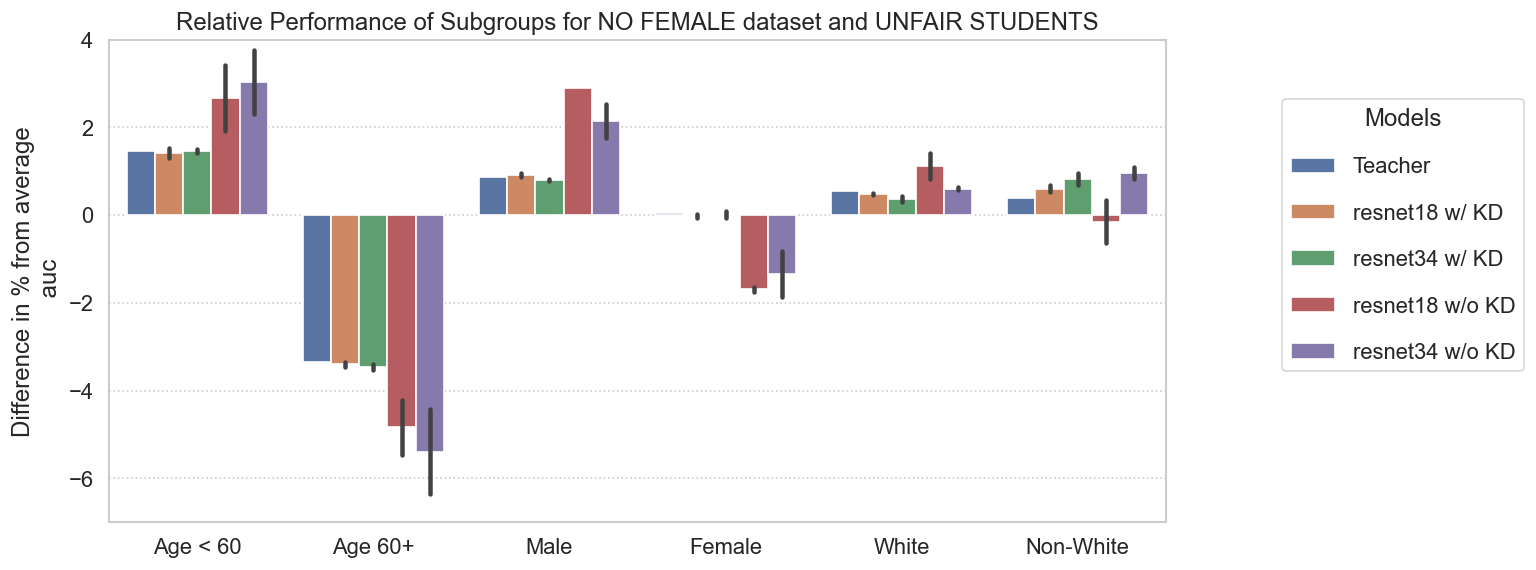

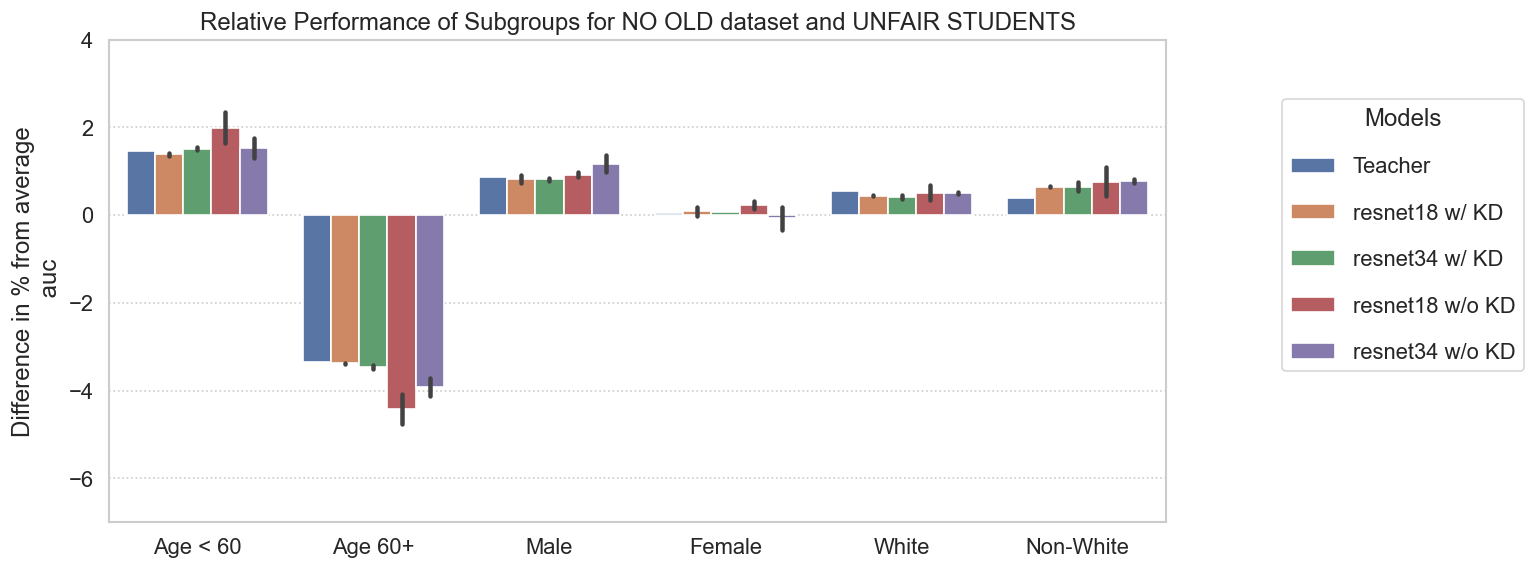

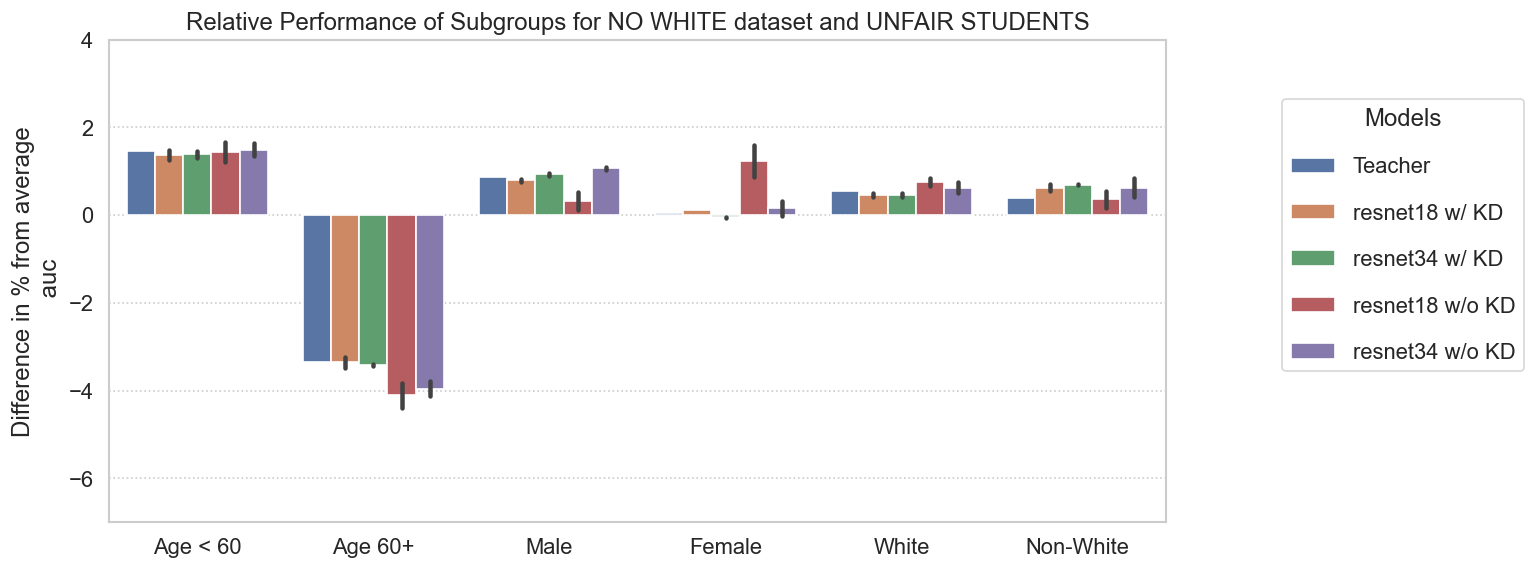

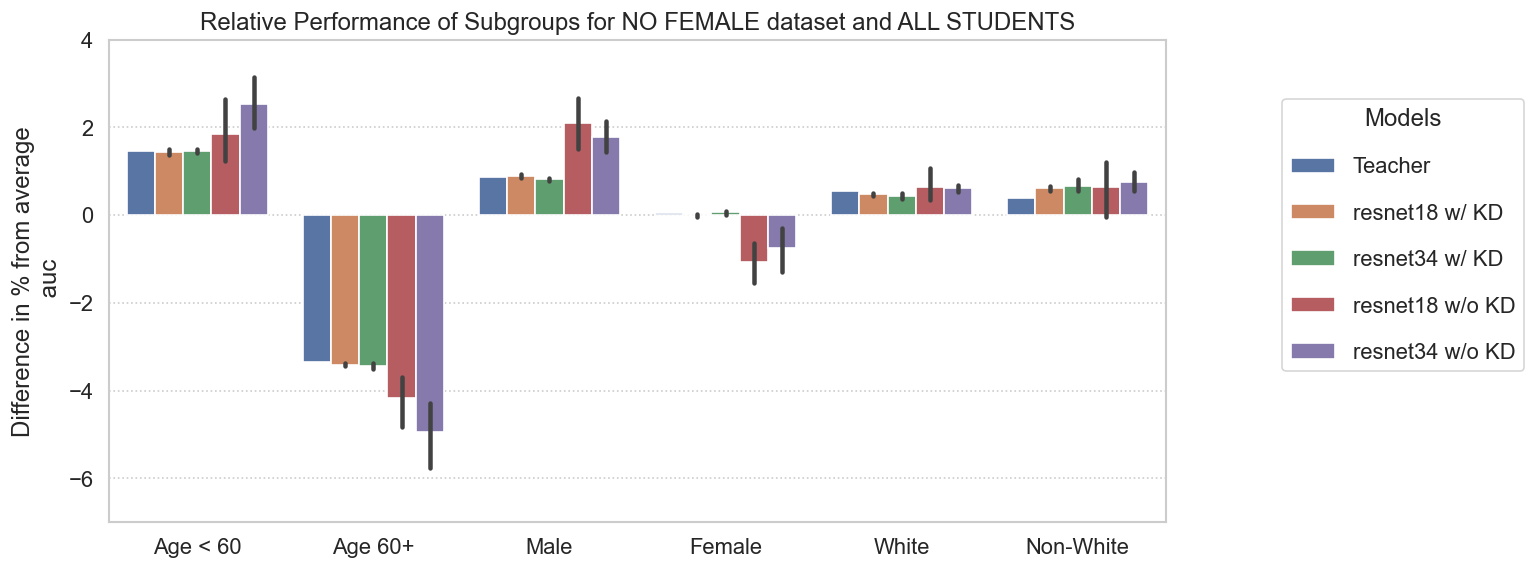

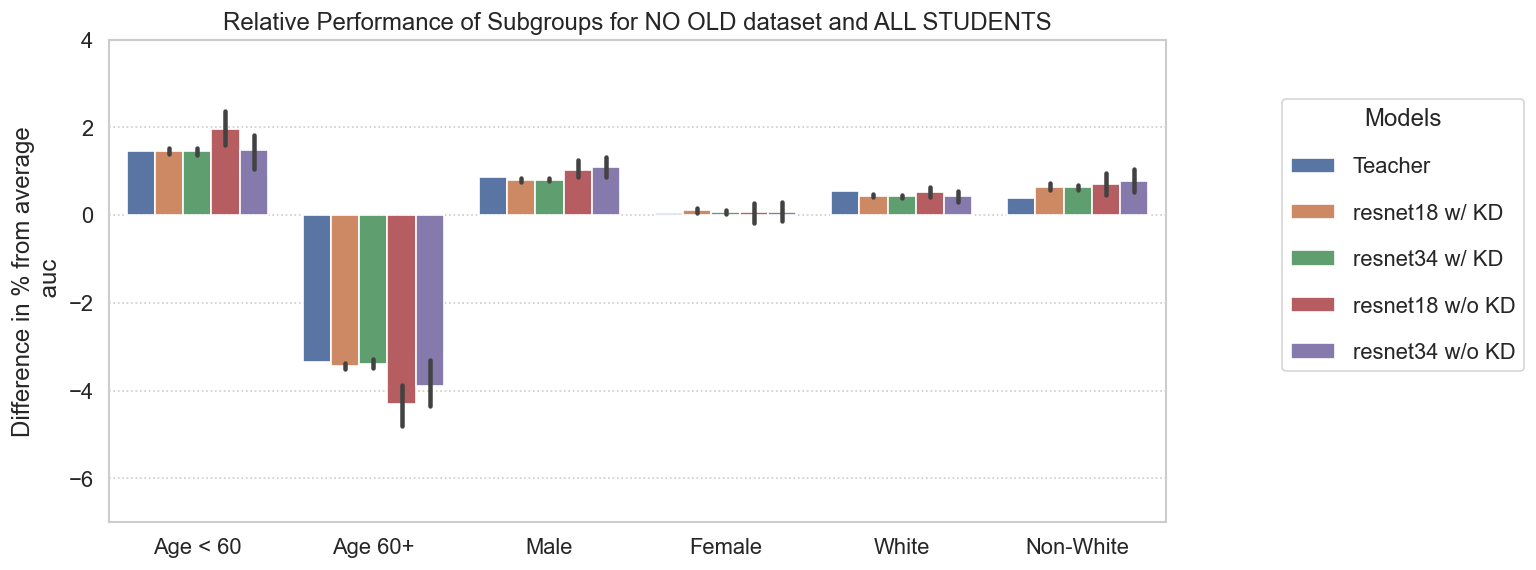

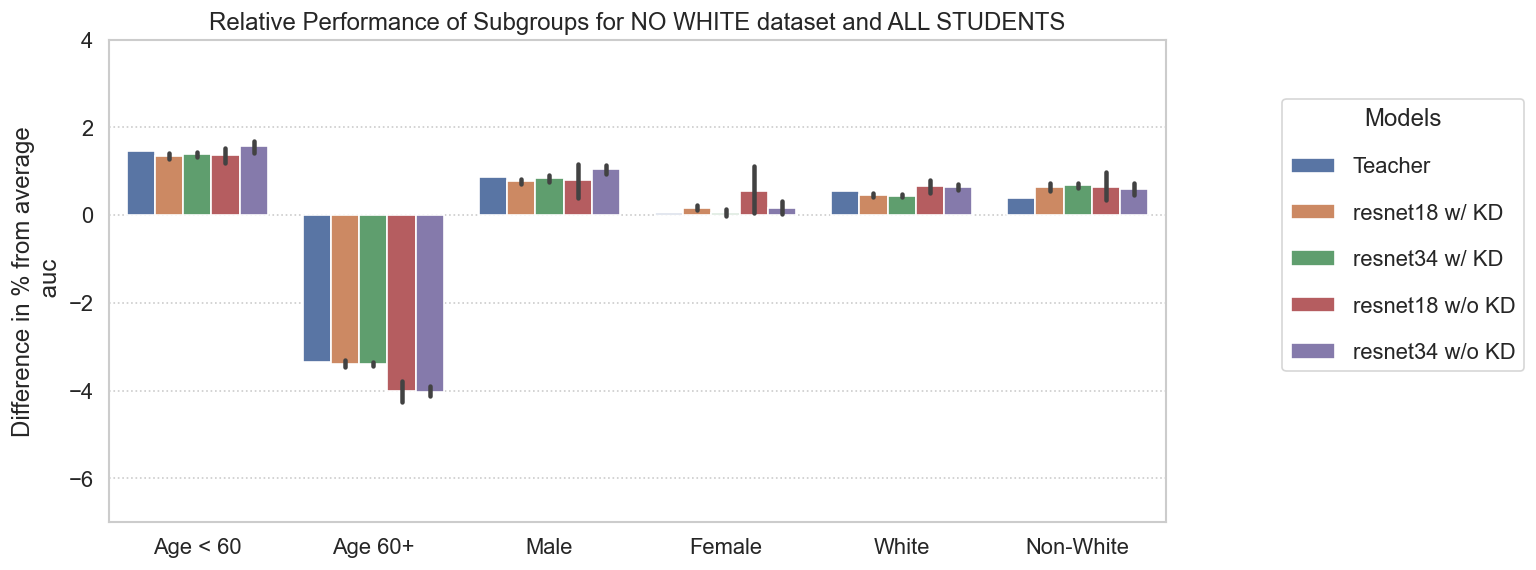

In [83]:
plot_relative_subgroup_performance(
    no_female_df,
    kd_no_female_df,
    original_df,
    'r34-sam1-s43',
    metric='auc',
    title='Relative Performance of Subgroups for NO FEMALE dataset and UNFAIR STUDENTS',
    unfair_seeds = True,
)

plot_relative_subgroup_performance(
    no_old_df,
    kd_no_old_df,
    original_df,
    'r34-sam1-s43',
    metric='auc',
    title='Relative Performance of Subgroups for NO OLD dataset and UNFAIR STUDENTS',
    unfair_seeds = True,
)

plot_relative_subgroup_performance(
    no_white_df,
    kd_no_white_df,
    original_df,
    'r34-sam1-s43',
    metric='auc',
    title='Relative Performance of Subgroups for NO WHITE dataset and UNFAIR STUDENTS',
    unfair_seeds = True,
)

plot_relative_subgroup_performance(
    no_female_df,
    kd_no_female_df,
    original_df,
    'r34-sam1-s43',
    metric='auc',
    title='Relative Performance of Subgroups for NO FEMALE dataset and ALL STUDENTS',
    unfair_seeds = False,
)

plot_relative_subgroup_performance(
    no_old_df,
    kd_no_old_df,
    original_df,
    'r34-sam1-s43',
    metric='auc',
    title='Relative Performance of Subgroups for NO OLD dataset and ALL STUDENTS',
    unfair_seeds = False,
)

plot_relative_subgroup_performance(
    no_white_df,
    kd_no_white_df,
    original_df,
    'r34-sam1-s43',
    metric='auc',
    title='Relative Performance of Subgroups for NO WHITE dataset and ALL STUDENTS',
    unfair_seeds = False,
)

### Individual Analysis (for specific student seeds)

#### Tables

In [4]:
student_ids = {
    'No Female': ['r18-sam1-s44', 'r18-sam1-s46', 'r34-sam1-s45', 'r34-sam1-s46'],
    'No Old': ['r18-sam1-s42', 'r18-sam1-s46', 'r34-sam1-s42', 'r34-sam1-s45'],
    'No White': ['r18-sam1-s42', 'r18-sam1-s46', 'r34-sam1-s44', 'r34-sam1-s45'],
}

def detailed_kd_table(
    resnet_df: pd.DataFrame, # baseline
    kd_df: pd.DataFrame,    # kd results
    original_df: pd.DataFrame, # df to take the teacher performance from
    kd_experiment: str, # experiment name (No Female or No Old)
    teacher_id: str, # teacher id
    # metrics: list[str] = ['model_id', 'auc', 'auc_gap', 'auc_gap_relative', 'age_auc_gap', 'sex_auc_gap', 'avg_auc_gap_relative'],
    metrics: list[str] = ['model_id', 'auc', 'auc_gap', 'auc_gap_relative', 'age_auc_gap_relative', 'sex_auc_gap_relative', 'race_auc_gap_relative', 'avg_auc_gap_relative'],
):
    teacher_df = original_df[original_df['model_id'] == teacher_id]
    teacher_df = teacher_df[metrics]
    teacher_df.set_index('model_id', inplace=True)

    # get the average baseline performance by model
    resnet_df = resnet_df[resnet_df['model_id'].isin(student_ids[kd_experiment])]
    resnet_df = resnet_df[metrics]
    resnet_df.set_index('model_id', inplace=True)
    resnet_df.sort_index(inplace=True)

    # get the average kd performance by model
    kd_df['model_id'] = kd_df['model_id'].str.split("_").map(lambda x: x[0])
    kd_df['model_id'] = kd_df['model_id'].replace('kd1-', '', regex=True)
    kd_df = kd_df[kd_df['model_id'].isin(student_ids[kd_experiment])]
    kd_df = kd_df[metrics]
    kd_df.set_index('model_id', inplace=True)
    kd_df.sort_index(inplace=True)

    # get the relative change in performance compared to the baseline
    kd_relative_df = ((kd_df - resnet_df) / resnet_df)

    teacher_df['Data'] = 'Teacher'
    resnet_df['Data'] = 'Baseline'
    kd_df['Data'] = 'KD'
    kd_relative_df['Data'] = 'Relative Change'
    df = pd.concat([teacher_df, resnet_df, kd_df, kd_relative_df])
    display(df)

print("No Female")
detailed_kd_table(
    no_female_df,
    kd_no_female_df,
    original_df,
    'No Female',
    'r34-sam1-s43',
)

print("No Old")
detailed_kd_table(
    no_old_df,
    kd_no_old_df,
    original_df,
    'No Old',
    'r34-sam1-s43',
)

print("No White")
detailed_kd_table(
    no_white_df,
    kd_no_white_df,
    original_df,
    'No White',
    'r34-sam1-s43',
)


No Female


auc   auc_gap  auc_gap_relative  age_auc_gap_relative  \
model_id                                                                   
r34-sam1-s43  0.859081  0.041050          0.047784              0.047784   
r18-sam1-s44  0.821229  0.058109          0.070758              0.060979   
r18-sam1-s46  0.800740  0.070374          0.087886              0.087886   
r34-sam1-s45  0.801364  0.055367          0.069091              0.066848   
r34-sam1-s46  0.803156  0.080742          0.100530              0.100530   
r18-sam1-s44  0.859553  0.042597          0.049557              0.049557   
r18-sam1-s46  0.856769  0.039625          0.046249              0.046249   
r34-sam1-s45  0.860771  0.043024          0.049983              0.049983   
r34-sam1-s46  0.860504  0.041164          0.047837              0.047837   
r18-sam1-s44  0.046667 -0.266938         -0.299622             -0.187302   
r18-sam1-s46  0.069971 -0.436938         -0.473760             -0.473760   
r34-sam1-s45  0.074133 -0.222929         -0.276560             -0.252290   
r34-sam1-s46  0.071404 -0.490175         -0.524153             -0.524153   

              sex_auc_gap_relative  race_auc_gap_relative  \
model_id                                                    
r34-sam1-s43              0.008222               0.001503   
r18-sam1-s44              0.046163               0.004778   
r18-sam1-s46              0.044967               0.020339   
r34-sam1-s45              0.043690               0.001651   
r34-sam1-s46              0.025715               0.005338   
r18-sam1-s44              0.008396               0.000115   
r18-sam1-s46              0.010040               0.002158   
r34-sam1-s45              0.008938               0.006660   
r34-sam1-s46              0.006796               0.002541   
r18-sam1-s44             -0.818115              -0.975859   
r18-sam1-s46             -0.776731              -0.893875   
r34-sam1-s45             -0.795430               3.032955   
r34-sam1-s46             -0.735735              -0.524055   

              avg_auc_gap_relative             Data  
model_id                                             
r34-sam1-s43              0.019170          Teacher  
r18-sam1-s44              0.037307         Baseline  
r18-sam1-s46              0.051064         Baseline  
r34-sam1-s45              0.037397         Baseline  
r34-sam1-s46              0.043861         Baseline  
r18-sam1-s44              0.019356               KD  
r18-sam1-s46              0.019483               KD  
r34-sam1-s45              0.021860               KD  
r34-sam1-s46              0.019058               KD  
r18-sam1-s44             -0.481154  Relative Change  
r18-sam1-s46             -0.618469  Relative Change  
r34-sam1-s45             -0.415450  Relative Change  
r34-sam1-s46             -0.565498  Relative Change

No Old


auc   auc_gap  auc_gap_relative  age_auc_gap_relative  \
model_id                                                                   
r34-sam1-s43  0.859081  0.041050          0.047784              0.047784   
r18-sam1-s42  0.833203  0.063167          0.075813              0.075813   
r18-sam1-s46  0.837442  0.059042          0.070502              0.070502   
r34-sam1-s42  0.840483  0.052078          0.061962              0.061962   
r34-sam1-s45  0.841036  0.049164          0.058456              0.058456   
r18-sam1-s42  0.859768  0.041079          0.047779              0.047779   
r18-sam1-s46  0.860612  0.041288          0.047976              0.047976   
r34-sam1-s42  0.860572  0.038246          0.044442              0.044442   
r34-sam1-s45  0.861415  0.043427          0.050414              0.050414   
r18-sam1-s42  0.031884 -0.349681         -0.369775             -0.369775   
r18-sam1-s46  0.027669 -0.300691         -0.319519             -0.319519   
r34-sam1-s42  0.023901 -0.265606         -0.282749             -0.282749   
r34-sam1-s45  0.024231 -0.116684         -0.137581             -0.137581   

              sex_auc_gap_relative  race_auc_gap_relative  \
model_id                                                    
r34-sam1-s43              0.008222               0.001503   
r18-sam1-s42              0.018553               0.006226   
r18-sam1-s46              0.006451               0.002617   
r34-sam1-s42              0.014055               0.002743   
r34-sam1-s45              0.016983               0.003325   
r18-sam1-s42              0.007252               0.000395   
r18-sam1-s46              0.005584               0.001984   
r34-sam1-s42              0.008952               0.001094   
r34-sam1-s45              0.007043               0.003772   
r18-sam1-s42             -0.609124              -0.936503   
r18-sam1-s46             -0.134409              -0.241808   
r34-sam1-s42             -0.363089              -0.601064   
r34-sam1-s45             -0.585262               0.134275   

              avg_auc_gap_relative             Data  
model_id                                             
r34-sam1-s43              0.019170          Teacher  
r18-sam1-s42              0.033531         Baseline  
r18-sam1-s46              0.026524         Baseline  
r34-sam1-s42              0.026253         Baseline  
r34-sam1-s45              0.026255         Baseline  
r18-sam1-s42              0.018476               KD  
r18-sam1-s46              0.018515               KD  
r34-sam1-s42              0.018163               KD  
r34-sam1-s45              0.020410               KD  
r18-sam1-s42             -0.448998  Relative Change  
r18-sam1-s46             -0.301955  Relative Change  
r34-sam1-s42             -0.308172  Relative Change  
r34-sam1-s45             -0.222632  Relative Change

No White


auc   auc_gap  auc_gap_relative  age_auc_gap_relative  \
model_id                                                                   
r34-sam1-s43  0.859081  0.041050          0.047784              0.047784   
r18-sam1-s42  0.821973  0.046284          0.056309              0.056309   
r18-sam1-s46  0.807749  0.048595          0.060161              0.060161   
r34-sam1-s44  0.824612  0.046026          0.055816              0.055816   
r34-sam1-s45  0.831647  0.042369          0.050946              0.050946   
r18-sam1-s42  0.853136  0.039139          0.045877              0.045877   
r18-sam1-s46  0.858513  0.038272          0.044579              0.044579   
r34-sam1-s44  0.858027  0.039523          0.046062              0.046062   
r34-sam1-s45  0.853805  0.039844          0.046667              0.046667   
r18-sam1-s42  0.037913 -0.154371         -0.185260             -0.185260   
r18-sam1-s46  0.062847 -0.212432         -0.259002             -0.259002   
r34-sam1-s44  0.040522 -0.141303         -0.174745             -0.174745   
r34-sam1-s45  0.026644 -0.059596         -0.084002             -0.084002   

              sex_auc_gap_relative  race_auc_gap_relative  \
model_id                                                    
r34-sam1-s43              0.008222               0.001503   
r18-sam1-s42              0.004564               0.002762   
r18-sam1-s46              0.014617               0.006910   
r34-sam1-s44              0.010026               0.000449   
r34-sam1-s45              0.011126               0.003313   
r18-sam1-s42              0.007832               0.000433   
r18-sam1-s46              0.006913               0.000406   
r34-sam1-s44              0.007754               0.002113   
r34-sam1-s45              0.009787               0.001810   
r18-sam1-s42              0.715846              -0.843341   
r18-sam1-s46             -0.527085              -0.941254   
r34-sam1-s44             -0.226593               3.703162   
r34-sam1-s45             -0.120329              -0.453855   

              avg_auc_gap_relative             Data  
model_id                                             
r34-sam1-s43              0.019170          Teacher  
r18-sam1-s42              0.021212         Baseline  
r18-sam1-s46              0.027229         Baseline  
r34-sam1-s44              0.022097         Baseline  
r34-sam1-s45              0.021795         Baseline  
r18-sam1-s42              0.018047               KD  
r18-sam1-s46              0.017299               KD  
r34-sam1-s44              0.018643               KD  
r34-sam1-s45              0.019421               KD  
r18-sam1-s42             -0.149194  Relative Change  
r18-sam1-s46             -0.364683  Relative Change  
r34-sam1-s44             -0.156301  Relative Change  
r34-sam1-s45             -0.108925  Relative Change

### Plots

In [19]:
from typing import List
metric_names = {
    'auc': 'AUC',
    'age_auc_group_0': 'Age < 60 AUC',
    'age_auc_group_1': 'Age 60+ AUC',
    'sex_auc_group_0': 'Male AUC',
    'sex_auc_group_1': 'Female AUC',
    'race_auc_group_0': 'White AUC',
    'race_auc_group_1': 'Non-White AUC',
    'avg_auc_gap': 'Avg AUC Gap',
    'age_auc_gap': 'Age AUC Gap',
    'sex_auc_gap': 'Sex AUC Gap',
    'race_auc_gap': 'Race AUC Gap',
    'age_eq_odds': 'Age Eq. Odds',
    'sex_eq_odds': 'Sex Eq. Odds',
    'race_eq_odds': 'Race Eq. Odds',
}

student_ids = {
    'No Female': ['r18-sam1-s44', 'r18-sam1-s46', 'r34-sam1-s45', 'r34-sam1-s46'],
    'No Old': ['r18-sam1-s42', 'r18-sam1-s46', 'r34-sam1-s42', 'r34-sam1-s45'],
    'No White': ['r18-sam1-s42', 'r18-sam1-s46', 'r34-sam1-s44', 'r34-sam1-s46'],
}

student_seeds = {
    'No Female':
    {
        'resnet18': [44, 46],
        'resnet34': [45, 46]
    },
    'No Old':
    {
        'resnet18': [42, 46],
        'resnet34': [42, 45]
    },
    'No White':
    {
        'resnet18': [42, 46],
        'resnet34': [44, 46]
    }
}

def individual_radar_plot(
    resnet_df: pd.DataFrame, # baseline
    kd_df: pd.DataFrame,    # kd results
    original_df: pd.DataFrame, # df to take the teacher performance from
    metrics: List[str],
    teacher_id: str,
    student_model: str, # resnet18 or resnet34
    experiment: str, # No Female or No Old
    title: str = 'title',
    is_performance: bool = True,
):
    # get the teacher performance
    teacher_df = original_df[original_df['model_id'] == teacher_id]
    teacher_df = teacher_df[metrics]
    teacher_df = teacher_df.rename(columns=metric_names)
    teacher_metrics = teacher_df.to_numpy()
    teacher_df = teacher_df.melt(var_name='metric', value_name='value')

    # get the average baseline performance by model
    student_baseline = resnet_df[(resnet_df['model_name'] == student_model) & (resnet_df['seed'].isin(student_seeds[experiment][student_model]))]
    student_baseline = student_baseline[metrics]
    student_baseline = student_baseline.rename(columns=metric_names)
    student_baseline = student_baseline.mean().to_frame().T
    baseline_metrics = student_baseline.to_numpy()
    student_baseline = student_baseline.melt(var_name='metric', value_name='value')

    # get the average kd performance by model
    student_kd = kd_df[(kd_df['model_name'] == student_model) & (kd_df['seed'].isin(student_seeds[experiment][student_model]))]
    student_kd = student_kd[metrics]
    student_kd = student_kd.rename(columns=metric_names)
    student_kd = student_kd.mean().to_frame().T
    kd_metrics = student_kd.to_numpy()
    student_kd = student_kd.melt(var_name='metric', value_name='value')

    # Add last element to create a circular effect
    teacher_df = teacher_df.append(teacher_df.iloc[0], ignore_index=True) 
    student_baseline = student_baseline.append(student_baseline.iloc[0], ignore_index=True) 
    student_kd = student_kd.append(student_kd.iloc[0], ignore_index=True) 

    fig = go.Figure()
    fig = px.line_polar(start_angle=90)

    # Calculate the Euclidean Distance
    distance_before = np.linalg.norm(teacher_metrics - baseline_metrics)
    distance_after = np.linalg.norm(teacher_metrics - kd_metrics)
    print(f"Distance before: {distance_before}")
    print(f"Distance after: {distance_after}")
    print(f"Distance difference: {(distance_before - distance_after) / distance_before * 100}")

    # PERFORMANCE
    if is_performance:
        fig.add_trace(go.Scatterpolar(
            r=teacher_df['value'],
            theta=teacher_df['metric'],
            name='Teacher',
        ))
        fig.add_trace(go.Scatterpolar(
            r=student_kd['value'],
            theta=student_kd['metric'],
            name=f'{student_model.capitalize()} w/ KD',
        ))
        fig.add_trace(go.Scatterpolar(
            r=student_baseline['value'],
            theta=student_baseline['metric'],
            name=f'{student_model.capitalize()} w/o KD',
        ))
        fig.update_layout(
        width=800,  # Set the width of the plot (in pixels)
        height=600,  # Set the height of the plot (in pixels)
        title={
            'text': title,
            'x': 0.5,  # Align the title in the center
            'y': 1.0,  # Adjust the vertical position of the title
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {'size': 14}  # Adjust the font size of the title
        },
        polar=dict(
            radialaxis=dict(
            visible=True,
            range=[0.7, 1.0],
            tickvals=list(np.arange(0.75, 1.0, 0.05)),  # Specify the position where ticks appear
            ),
        ),
            showlegend=True,
        )

    # FAIRNESS
    else:
        fig.add_trace(go.Scatterpolar(
            r=student_baseline['value'],
            theta=student_baseline['metric'],
            name=f'{student_model.capitalize()} w/o KD',
            line_color='#AB63FA'
        ))
        fig.add_trace(go.Scatterpolar(
            r=student_kd['value'],
            theta=student_kd['metric'],
            name=f'{student_model.capitalize()} w/ KD',
            line_color='#00CC96'
        ))
        fig.add_trace(go.Scatterpolar(
            r=teacher_df['value'],
            theta=teacher_df['metric'],
            name='Teacher',
            line_color='#EF553B'
        ))
        fig.update_layout(
        width=800,  # Set the width of the plot (in pixels)
        height=600,  # Set the height of the plot (in pixels)
        title={
            'text': title,
            'x': 0.5,  # Align the title in the center
            'y': 1.0,  # Adjust the vertical position of the title
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {'size': 14}  # Adjust the font size of the title
        },
        polar=dict(
            radialaxis=dict(
            visible=True,
            # range=[0.0, 0.15],
            # tickvals=list(np.arange(0.75, 1.0, 0.05)),  # Specify the position where ticks appear
            ),
        ),
            showlegend=True,
        )

    fig.update_traces(fill='toself')
    fig.show()


In [20]:
individual_radar_plot(
    no_female_df,
    kd_no_female_df,
    original_df,
    metrics=['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    teacher_id='r34-sam1-s43',
    student_model='resnet18',
    title='NO FEMALE data subgroup performance for UNFAIR ResNet18 seeds',
    is_performance=True,
    experiment='No Female'
)

individual_radar_plot(
    no_female_df,
    kd_no_female_df,
    original_df,
    metrics=['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    teacher_id='r34-sam1-s43',
    student_model='resnet34',
    title='NO FEMALE data subgroup performance for UNFAIR ResNet34 seeds',
    is_performance=True,
    experiment='No Female'
)

individual_radar_plot(
    no_old_df,
    kd_no_old_df,
    original_df,
    metrics=['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    teacher_id='r34-sam1-s43',
    student_model='resnet18',
    title='NO OLD data subgroup performance for UNFAIR ResNet18 seeds',
    is_performance=True,
    experiment='No Old'
)

individual_radar_plot(
    no_old_df,
    kd_no_old_df,
    original_df,
    metrics=['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    teacher_id='r34-sam1-s43',
    student_model='resnet34',
    title='NO OLD data subgroup performance for UNFAIR ResNet34 seeds',
    is_performance=True,
    experiment='No Old'
)

individual_radar_plot(
    no_white_df,
    kd_no_white_df,
    original_df,
    metrics=['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    teacher_id='r34-sam1-s43',
    student_model='resnet18',
    title='NO WHITE data subgroup performance for UNFAIR ResNet18 seeds',
    is_performance=True,
    experiment='No White'
)

individual_radar_plot(
    no_white_df,
    kd_no_white_df,
    original_df,
    metrics=['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    teacher_id='r34-sam1-s43',
    student_model='resnet34',
    title='NO WHITE data subgroup performance for UNFAIR ResNet34 seeds',
    is_performance=True,
    experiment='No White'
)

Distance before: 0.1348039525824004
Distance after: 0.0030284954903571706
Distance difference: 97.75340749856281
Mean agreement before: 94.14250310466777
Mean agreement after: 99.87083194018591
Mean agreement difference: -6.084742434720879


/tmp/ipykernel_556131/2054196368.py:78: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_556131/2054196368.py:79: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_556131/2054196368.py:80: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Distance before: 0.15431645714282613
Distance after: 0.006495939188870838
Distance difference: 95.79050782454227
Mean agreement before: 93.24929900166295
Mean agreement after: 99.78233099341908
Mean agreement difference: -7.005985097689181


/tmp/ipykernel_556131/2054196368.py:78: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_556131/2054196368.py:79: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_556131/2054196368.py:80: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Distance before: 0.06613763460620524
Distance after: 0.003939763351896012
Distance difference: 94.04308397880567
Mean agreement before: 97.14359419912417
Mean agreement after: 99.85414736326496
Mean agreement difference: -2.7902541454094445


/tmp/ipykernel_556131/2054196368.py:78: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_556131/2054196368.py:79: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_556131/2054196368.py:80: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Distance before: 0.04980440933751688
Distance after: 0.006292499583055774
Distance difference: 87.3655773318935
Mean agreement before: 97.8315672448772
Mean agreement after: 99.74754689678011
Mean agreement difference: -1.9584472638643422


/tmp/ipykernel_556131/2054196368.py:78: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_556131/2054196368.py:79: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_556131/2054196368.py:80: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Distance before: 0.12031231671080744
Distance after: 0.009148097255582934
Distance difference: 92.39637511297197
Mean agreement before: 94.69937605455826
Mean agreement after: 99.60822989874842
Mean agreement difference: -5.183617937843719


/tmp/ipykernel_556131/2054196368.py:78: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_556131/2054196368.py:79: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_556131/2054196368.py:80: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Distance before: 0.0904525968116237
Distance after: 0.003489911079140305
Distance difference: 96.14172372916127
Mean agreement before: 96.007145742747
Mean agreement after: 99.8506470871325
Mean agreement difference: -4.003349245153311


/tmp/ipykernel_556131/2054196368.py:78: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_556131/2054196368.py:79: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_556131/2054196368.py:80: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

